##### [2021-11-02] [PT] Planter code Testing.
    good to run!
    
#### [2021-11-03] check with fixed random_state=42


#### [2021-11-05] 

     
#### [2021-11-06] test multiple models

#### [2021-11-07] (1)Test W/WO Aug. (2) model.trainable=True. (3)Test tl with training=false.


    #### [2021-11-07] V2 no function code for get base_model and unfreeze fine tune models
    
        
            



# 101 Course of transfer learning and Fine tune 2021-01-01

## Intro
## Foot_Plantar_Pressure_Points

/Users/lsw/work.Local/TF2_books_code_test/course_2020/Foot_Plantar_Pressure_Points

todo: move to note.py


## import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf






In [ ]:
# !sh ../install_env.sh

In [2]:
!export TF_ENABLE_AUTO_MIXED_PRECISION=0

In [3]:
%reset -f

In [4]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer


from pytictoc import TicToc

t = TicToc() #create instance of class

t.tic() #Start time

In [5]:
print(tf.__version__)
print(cv2.__version__)

2.5.0
4.5.3


### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [6]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [7]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [8]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [9]:

# data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'



# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# df[1335:]



# # data-train #
# ann = 'annotation_1345_good.csv'
# im_p = 'train/images/'



# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'

# # data-train-HPL-1223
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'



# # HAL_LABELING-train #
# ann = '20211109-133352/HAL-Labeling_20211109-133352_rs42_noAug_df1345_.csv'
# im_p = 'train/images/'


# HAL_LABELING-train 2345 #
ann = 'HAL-Labeling-2345_20211109-133352_.csv'
im_p = 'train_HAL_2345/'






df = pd.read_csv(ann)
df[:10]

images         x1          y1         x2          y2
0  image_0001.png  54.451679  135.123199  75.394951  384.379639
1  image_0002.png  61.442509  138.646210  40.848324  383.405762
2  image_0003.png  46.754406  117.371490  75.725739  367.023193
3  image_0004.png  65.820023  119.129929  33.653645  375.819153
4  image_0005.png  58.164391  147.843231  83.922615  380.064240
5  image_0006.png  55.113388  146.362488  29.693220  380.158783
6  image_0007.png  53.298878  121.596741  66.248665  366.226379
7  image_0008.png  61.680321  121.828506  35.355770  374.187622
8  image_0009.png  71.450905  159.187805  78.744621  383.658051
9  image_0010.png  59.819286  149.161926  32.126545  382.943542

In [10]:
len(df)

2345

#### Shuffle and reset index

In [11]:
# reset index
# df = df.sample(frac=1).reset_index(drop=True)

# fixed shuffle for compare, random_state=42
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [12]:
df.head(10)

images         x1          y1         x2          y2
0  image_9046.png  57.987431  135.191193  82.987144  384.224365
1  image_0714.png  52.403492  108.692627  81.000786  380.177673
2  image_9651.png  61.724247  154.479889  80.638802  381.960144
3  image_0862.png  44.308567  134.017624  80.541679  381.659424
4  image_9552.png  56.855289  100.882408  33.878914  376.241638
5  image_0365.png  63.624214  123.942627  72.653557  367.053711
6  image_6400.jpg  62.383018  107.674316  31.872419  381.231628
7  image_0115.png  56.149105  138.978195  65.729118  377.132874
8  image_6140.png  63.349453  141.390839  31.346119  370.647827
9  image_9324.png  56.813637  145.916840  33.818947  383.117554

See, the image_####.jpg now are random.

In [13]:
# fixed 1424 shuffle for compare, random_state=42
# 
# 0	image_6186.jpg	59	139	39	386
# 1	image_0678.png	60	138	78	384
# 2	image_6085.png	68	142	83	381
# 3	image_6006.png	63	120	32	386
# 4	image_0945.png	64	132	31	370
# 5	image_0539.png	63	160	39	366
# 6	image_0995.png	54	150	37	376
# 7	image_0725.png	49	136	32	383
# 8	image_0071.png	51	134	70	385
# 9	image_0124.png	65	136	33	384

In [14]:
# fixed 1345 shuffle for compare, random_state=42

# 0	image_0299.png	50	103	73	383
# 1	image_0274.png	50	154	27	369
# 2	image_6298.jpg	61	153	35	384
# 3	image_0218.jpg	52	138	79	381
# 4	image_0231.png	60	109	24	384
# 5	image_0841.png	67	113	30	374
# 6	image_0873.png	54	155	24	381
# 7	image_0168.jpg	60	119	31	380
# 8	image_6331.jpg	69	131	79	385
# 9	image_0078.png	63	104	19	378

#### Create tf.dataset (DS)

In [15]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [16]:
# len(list_ds)#.shape() #take(1)

In [17]:
# # check The type specification of an element of this dataset.
# list_ds.element_spec


In [18]:
# for f,x1,y1,x2,y2 in list_ds.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

In [19]:
# # use np decode to UTF-8
# print(f.numpy().decode('UTF-8'))

In [20]:
# len(list_ds)

#### Check ds iterator for consuming

In [21]:
# # create a Python iterator

# it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [22]:
# # using iter and consuming its elements using next: every print different image name.

# for i in range(4):
#     image, x1, y1, x2, y2 = next(it_list_ds)
#     print(image.numpy(), x1.numpy(), y1.numpy())

In [23]:
# # image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# # pred = model.predict_on_batch(image_batch)


# for i in range(4):
#     image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
#     print(image, x1, y1, x2, y2)
    
# iter_test_list = list_ds.as_numpy_iterator()
# print("===== Create iterator once and pull out to above cell. =====")
# for i in range(4):
#     image, x1, y1, x2, y2 = iter_test_list.next()
#     print(image, x1, y1, x2, y2)


#### Process path to image tensor in DS

In [24]:

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [25]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [26]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

# for img, [x, y] in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('f', f.dtype)
# print('x', x.dtype)

In [27]:
# x

In [28]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

In [29]:
# split Toe
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

print(len(train_ds_map_toe))
print(val_size)
print(tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
print(tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

2345
469
1876
469


In [30]:
# split Heel
val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

print(len(train_ds_map_heel))
print(val_size)
print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

2345
469
1876


# new split TVT train/val/test

In [31]:
# TVT ratio 0.7:0.15:0.15

In [32]:
# test_list_ds = tf.data.Dataset.from_tensor_slices(range(20))

# # for ele in test_list_ds:
# #     print(ele)

    
# val_size = int(tf.data.experimental.cardinality(test_list_ds).numpy() * 0.15)
# print(" val_size:", val_size)    
    
# print("Train")
# for ele in test_list_ds.skip(val_size*2):
#     print('skip', ele)

# print("temp_take")    
# temp_take_list_ds = test_list_ds.take(val_size*2)

# print("val")
# for ele in temp_take_list_ds.take(val_size):
#     print('take', ele)

# print("Test")
# for ele in temp_take_list_ds.skip(val_size):
#     print('take', ele)


In [33]:
# # split Toe TVT train/val/test


# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.15)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# print(" val_size:", val_size)

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size+val_size)
# temp_tdmt_s = train_ds_map_toe.take(val_size+val_size)

# valid_ds_map_toe_s = temp_tdmt_s.take(val_size)
# test_ds_map_toe_s = temp_tdmt_s.skip(val_size)

# print(len(train_ds_map_toe))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())
# print(tf.data.experimental.cardinality(test_ds_map_toe_s).numpy())

In [34]:
# # split Heel TVT train/val/test


# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.15)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)
# print(" val_size:", val_size)

# train_ds_map_heel_s = train_ds_map_heel.skip(val_size+val_size)
# temp_tdmh_s = train_ds_map_heel.take(val_size+val_size)

# valid_ds_map_heel_s = temp_tdmh_s.take(val_size)
# test_ds_map_heel_s = temp_tdmh_s.skip(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())
# print(tf.data.experimental.cardinality(test_ds_map_heel_s).numpy())

# Albumentation pipeline

In [35]:

# # for NO keypoint augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label








# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA (alpha=0.1, always_apply=False, p=1),
            A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
            A.HorizontalFlip(p=0.5),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
            )



# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)]
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
#     print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

#     print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])
#     print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(keypoints, [2,]) # for 'tf ds tarining'
#     print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 


def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


#### prepare train_ds_prefetch

In [36]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [37]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [38]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# Toe ds_pre
train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=False) #True False
valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# test_ds_pre_toe_s = configure_for_performance_cache_val(test_ds_map_toe_s)



# Heel ds_pre
train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=False) #True
valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

# test_ds_pre_heel_s = configure_for_performance_cache_val(test_ds_map_heel_s)

Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]


#### Check ds_prefetch samples

In [39]:
# create it_ds once
it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
 [min,max]: 0 255
Check lables: [65.05197144 19.60980225]
 [min,max]: 3 255
Check lables: [62.21741867 68.73348999]
 [min,max]: 0 255
Check lables: [57.80514526 77.39373779]
 [min,max]: 0 255
Check lables: [53.50343323 70.01864624]
 [min,max]: 1 255
Check lables: [58.31755447 54.67350769]
 [min,max]: 3 255
Check lables: [63.4928894  46.64650726]
 [min,max]: 0 255
Check lables: [54.91617203 33.33456421]
 [min,max]: 3 255
Check lables: [74.15850067 52.78651428]
 [min,max]: 3 255
Check lables: [56.49146652 67.94039917]
 [min,max]: 5 255
Check lables: [62.96115494 79.31741333]


/home/u3148947/.local/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


 [min,max]: 0 255
Check lables: [57.40681076 58.81362915]
 [min,max]: 2 255
Check lables: [62.11397552 40.7741394 ]
 [min,max]: 0 255
Check lables: [70.78616333 58.30712891]
 [min,max]: 0 255
Check lables: [55.77073288 65.30638123]
 [min,max]: 0 255
Check lables: [60.3301506  64.67793274]
 [min,max]: 3 255
Check lables: [61.83460236 52.66958618]
CPU times: user 3.19 s, sys: 394 ms, total: 3.59 s
Wall time: 7.16 s


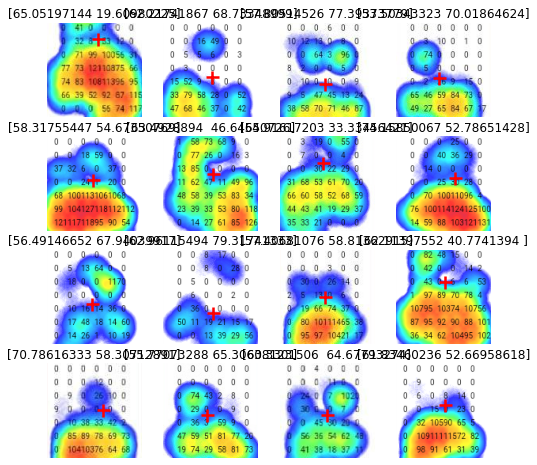

In [40]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_toe_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    
    # 2021-11-05
    # Check jpg, png agter ds is [0-255]
    print(' [min,max]:', image_batch[i].numpy().min() , image_batch[i].numpy().max())
    
    
    
    print(f'Check lables: {label_batch[i]}')


In [41]:
# create it_ds once
it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
Check lables: [ 79.98514557 102.70449829]
Check lables: [ 78.41597748 101.73468018]
Check lables: [74.73649597 86.94784546]
Check lables: [ 76.11630249 101.88922119]
Check lables: [ 76.00644684 102.48712158]
Check lables: [ 77.84918976 102.88250732]
Check lables: [79.55078888 97.62530518]
Check lables: [ 28.18521309 102.15612793]
Check lables: [76.61341095 80.30072021]
Check lables: [31.69756508 85.84732056]
Check lables: [ 40.2902298  102.66156006]
Check lables: [32.00152969 71.07049561]
Check lables: [ 83.54949188 104.63998413]
Check lables: [20.79517174 84.1194458 ]
Check lables: [ 71.76673126 101.8560791 ]
Check lables: [ 35.49517441 103.08587646]
CPU times: user 2.82 s, sys: 167 ms, total: 2.99 s
Wall time: 1.16 s


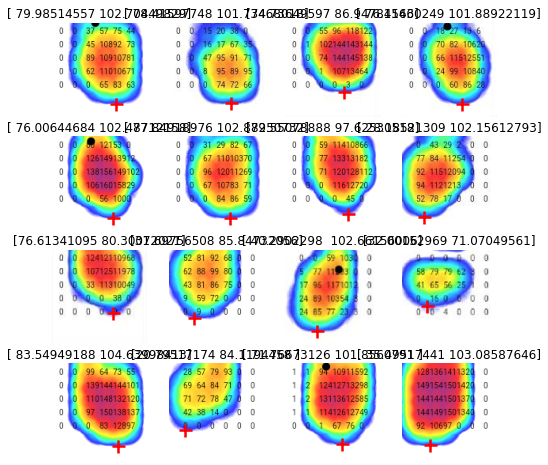

In [42]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_heel_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    print(f'Check lables: {label_batch[i]}')

In [43]:
# create it_ds once
it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
[min,max]: 0 255
Check lables: [57.98743057 55.19119263]
[min,max]: 3 255
Check lables: [52.40349197 28.69262695]
[min,max]: 3 255
Check lables: [61.72424698 74.47988892]
[min,max]: 3 255
Check lables: [44.30856705 54.0176239 ]
[min,max]: 3 255
Check lables: [56.85528946 20.88240814]
[min,max]: 0 255
Check lables: [63.62421417 43.94262695]
[min,max]: 0 255
Check lables: [62.38301849 27.67431641]
[min,max]: 0 255
Check lables: [56.14910507 58.97819519]
[min,max]: 3 255
Check lables: [63.34945297 61.39083862]
[min,max]: 3 255
Check lables: [56.81363678 65.9168396 ]
[min,max]: 1 255
Check lables: [52.66153717 43.4229126 ]
[min,max]: 2 255
Check lables: [61.72724152 55.6736145 ]
[min,max]: 1 255
Check lables: [58.76741409 40.86549377]
[min,max]: 3 255
Check lables: [58.98467255 57.52828979]
[min,max]: 3 255
Check lables: [61.73365784 53.76464844]
[min,max]: 0 255
Check lables: [62.67862701 52.06555176]
CPU times: user 395 ms, sys: 30.8 ms, total: 42

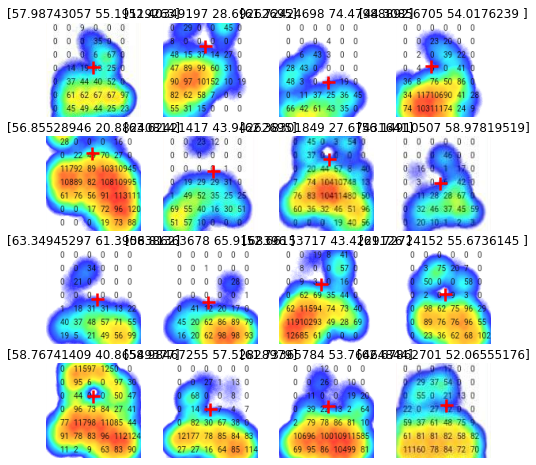

In [44]:
%%time

# for albu keypoint

# for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
image_batch, label_batch = next(it_valid_ds_pre_toe_s)

plt.figure(figsize=(8, 8))
# for images, labels in valid_ds_pre_toe_s.take(1):
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)
    
    # 2021-11-05
    # Check jpg, png agter ds is [0-255]
    print('[min,max]:', image_batch[i].numpy().min() , image_batch[i].numpy().max())

    print(f'Check lables: {label_batch[i]}')
        

In [45]:
# %%time

# #2021-01-30
# # for change default [x, y] tuple to x, y

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, x, y in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(x[i].numpy(), y[i].numpy(), 'r+', markersize=13, mew=2.5)

In [46]:
# %%time

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'r+', markersize=13, mew=2.5)

In [47]:
# %%time

# # NOrmalized xy to [0, 1] #

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0]*120, labels[i].numpy()[1]*120, 'r+', markersize=13, mew=2.5)

In [48]:
# %%time

# # NOrmalized xy to [0, 1] #

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0]*120, labels[i].numpy()[1]*120, 'r+', markersize=13, mew=2.5)

In [49]:
# %%time

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels))
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(str(labels[i].numpy()))
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'b+', markersize=13, mew=2.5)
# #         print((labels[i].numpy()[0], labels[i].numpy()[1]))

In [50]:
# create it_ds once
# it_train_ds_pre_toe = iter(train_ds_pre_toe_s)

In [51]:
# image_batch, label_batch = next(it_train_ds_pre_toe)

# plt.figure(figsize=(18, 18))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title('x1,y1:' + str(label_batch[i].numpy()))
#     plt.axis("off")
    
#     #print(label_batch[i])
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

### [OLD] Split train_ds_pre

##### train_ds_pre_s
##### valid_ds_pre_s 

### re-set to toe/heel split
##### train_ds_pre_toe_s
##### valid_ds_pre_toe_s

##### train_ds_pre_heel_s
##### valid_ds_pre_heel_s

#### split Toe

In [52]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_pre_toe).numpy() * 0.2)

# train_ds_pre_toe_s = train_ds_pre_toe.skip(val_size)
# valid_ds_pre_toe_s = train_ds_pre_toe.take(val_size)

# print(len(train_ds_pre_toe))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_pre_toe_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_pre_toe_s).numpy())

#### split Heel

In [53]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_pre_heel).numpy() * 0.2)

# train_ds_pre_heel_s = train_ds_pre_heel.skip(val_size)
# valid_ds_pre_heel_s = train_ds_pre_heel.take(val_size)

# print(len(train_ds_pre_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_pre_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_pre_heel_s).numpy())

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [54]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [55]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [56]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [57]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [58]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [59]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [60]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [61]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [62]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [63]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [64]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [65]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [66]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [67]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [68]:
# ed_metric_2d_mean(y_true, y_pred).numpy()

In [69]:
# ed_metric_2d_mean(y_true, y_pred)

### Test howto contact the all pred reuslt for submit.CSV

In [70]:
# # append test
# aa= [[ 32.0332  , 105.49409 ],
#        [ 68.21191 ,  83.02111 ],
#        [ 32.07095 ,  99.04422 ]]
# bb= [[ 11.0332  , 22.49409 ],
#        [ 33.21191 ,  44.02111 ]]
# all_pred = np.append(aa, bb, axis=0)#上下接

In [71]:
# all_pred

In [72]:
# all_pred.shape

In [73]:
# all_pred_12 = np.append(all_pred, all_pred, axis=1)#左右接

In [74]:
# all_pred_12

In [75]:
# all_pred_12.shape

# multi output regression model

In [76]:
# from tensorflow import keras 
# from tensorflow.keras import models
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

# model_name = 'simple-Conv2D'

# model = models.Sequential()
# model.add(Conv2D(16, (3, 3), input_shape=(120, 120, 3), activation='relu'))#fix by filters, (ks,ks)
# # model.add(Conv2D(3, 3, input_shape=(120, 120, 3), activation='relu'))# still run
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(32, 3, 3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(64, 3, 3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(2))

In [77]:
# ep_num = 1000


In [78]:
# model.compile(optimizer='adam', loss=ed_metric_2d_mean)#, metrics=['mae'])


In [79]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=100), #patience=step_size ot ep_num
#     tf.keras.callbacks.LearningRateScheduler(clr3),#,clr2_heel  lrfn2_heel decay or lrfn or lrfn2. clr
# #     lr_reduceonplateau,
# #     PrintLRheel()
# ]

In [80]:
# %%time
# # fit the model on all data

# ### re-set to toe/heel split
# ##### train_ds_pre_toe_s
# ##### valid_ds_pre_toe_s
# model.fit(train_ds_pre_toe_s, verbose=1, epochs=ep_num, validation_data=valid_ds_pre_toe_scallbacks=callbacks)#, validation_split=0.1)

# ##### train_ds_pre_heel_s
# ##### valid_ds_pre_heel_s
# # model.fit(train_ds_pre_heel_s, verbose=1, epochs=ep_num, validation_data=valid_ds_pre_heel_s)#, validation_split=0.1)


In [81]:
# model.evaluate(valid_ds_pre_toe_s)

In [82]:
# model.evaluate(valid_ds_pre_heel_s)

# EFNE Training

maybe mae better than ed loss?

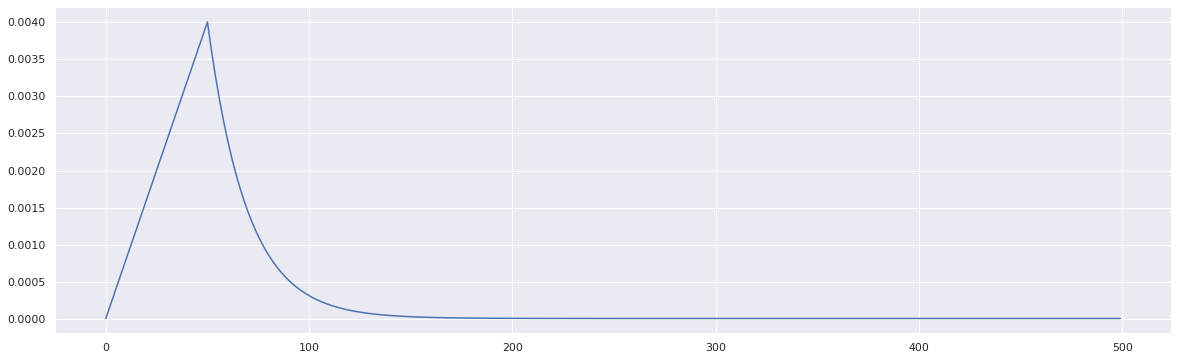

In [83]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.004
    lr_min = 0.00001
    lr_start = 0.00001

    lr_init_ep = 0
    lr_ramp_ep = 50
    lr_sus_ep  = 0 #10
    lr_decay   = 0.95

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [84]:
print('{} ~ {}'.format(min(y), max(y)))

1e-05 ~ 0.004


In [85]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 1e-05

1	 8.980000000000001e-05

2	 0.00016960000000000003

3	 0.00024940000000000004

4	 0.0003292000000000001

5	 0.0004090000000000001

6	 0.0004888000000000001

7	 0.0005686000000000002

8	 0.0006484000000000001

9	 0.0007282000000000001

10	 0.0008080000000000001

11	 0.0008878000000000002

12	 0.0009676000000000002

13	 0.0010474000000000002

14	 0.0011272000000000003

15	 0.0012070000000000002

16	 0.0012868000000000003

17	 0.0013666000000000004

18	 0.0014464000000000002

19	 0.0015262000000000003

20	 0.0016060000000000002

21	 0.0016858000000000003

22	 0.0017656000000000004

23	 0.0018454000000000003

24	 0.0019252000000000004

25	 0.0020050000000000003

26	 0.0020848000000000004

27	 0.0021646000000000005

28	 0.0022444000000000006

29	 0.0023242000000000007

30	 0.0024040000000000003

31	 0.0024838000000000004

32	 0.0025636000000000005

33	 0.0026434000000000006

34	 0.0027232000000000007

35	 0.0028030000000000004

36	 0.0028828000000000005

37	 0.0029626000000000006

In [86]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [87]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [88]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [89]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [90]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [91]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [92]:
model_name = 'EfficientNetB0'

# 2021-11-05 test
# model_name = 'EfficientNetB3'

# model_name = 'EfficientNetB7'


# model_name = 'VGG16'

In [93]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

th = 'toe'
# th = 'heel'

print(get_best_model_name(th))

best_model_name = get_best_model_name(th)


best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)

./20211111-141327/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
best_model_name: ./20211111-141327/toe_EfficientNetB0_bs64_w120_best_val_loss.h5


In [94]:
""" TensorBoard callback will slowdown the training.
tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=False, write_steps_per_second=False, update_freq='epoch',
    profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs
)
"""

logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [95]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=50), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
    PrintLRtoe()
]

In [96]:
# create keras model

# model_name = 'EfficientNetB0'

# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2

# with strategy.scope():
    
#     base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",drop_connect_rate=drop_connect_rate) #{'imagenet', None}

#     # Freeze the pretrained weights
#     base_model.trainable = False
#     print("base_model.trainable : ", base_model.trainable)

#     # Rebuild top
#     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
#     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
#     outputs = tf.keras.layers.Dense(2)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

#     # Compile new model
#     model_toe = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

#     model_toe.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)
#                       #metrics=[tf.keras.metrics.MeanSquaredError()])
#                       #metrics=[edRescal])
    
# #     loss=tf.keras.losses.MeanSquaredError()
#                     #ed_metric_2d_mean,#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                     #metrics=['mae', 'accuracy'])#!!note!! for keypoint regression should use MSE loss 01/29#
        



# # # AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False)
# # model_toe.compile(optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
# #                 loss=ed_metric_2d_mean)#,#, ed_loss ed_metric_2d ed_metric_2d_mean            
# #                 #metrics=['mae', 'accuracy'])


# # =========================================================================================================






# Transfer learning from pre-trained weights
# def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
#     base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    
#     # Freeze the pretrained weights
#     base_model.trainable = False
#     print("base_model.trainable : ", base_model.trainable)

#     # Rebuild top
#     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
#     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
#     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

#     # Compile new model
#     model = tf.keras.Model(base_model.input, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
# #     fine_tune_at = 20 #10 #241 #20
# #     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
# #     for layer in model_toe.layers[-fine_tune_at:]:
# #         if not isinstance(layer, tf.keras.layers.BatchNormalization):
# #             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model



# # =========================================================================================================
# 2021-11-08 

# Test base_model(inputs, training=False)
def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    
    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)

    # How to add training=False in base_model create
    inputs = tf.keras.Input(shape=(120, 120, 3))
    b_m_output = base_model(inputs, training=False)
    
    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(b_m_output) #(base_model.output)
    #BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(gap2d)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(inputs, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)

    
    return model, base_model

In [97]:
top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2
# with strategy.scope():
model_toe, base_model = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate) # for efnet, Xincept


base_model.trainable :  False


In [98]:
len(model_toe.layers)

5

In [99]:
tt = 0
nt = 0
for layer in model_toe.layers:
    if layer.trainable:
        tt +=1
        print(f'{layer.name}')
    else:
        nt +=1
print(f'tt: {tt}, nt:{nt}')

input_2
global_average_pooling2d
dropout
dense
tt: 4, nt:1


In [100]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')

In [101]:
count_model_trainOrNot_layers(model_toe)

tt: 4, nt:1, total layers:5


In [102]:
model_toe.summary()

Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 4, 4, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


In [103]:
#base_model.summary()

In [104]:
%%time

# Check TF only IF comment this cell

# fit the model on all data
history_toe = model_toe.fit(train_ds_pre_toe_s, 
                      verbose=1, 
                      epochs=ep_num_transf, 
                      validation_data=valid_ds_pre_toe_s, 
                      callbacks=callbacks)#, validation_split=0.1)

Epoch 1/500

[20211111-1413-30] Learning rate for epoch 1 is 9.999999747378752e-06
30/30 [==============================] - 16s 354ms/step - loss: 79.6585 - val_loss: 79.4549

Epoch 00001: val_loss improved from inf to 79.45490, saving model to ./20211111-141327/toe_EfficientNetB0_bs64_w120_best_val_loss.h5


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/500

[20211111-1413-47] Learning rate for epoch 2 is 8.97999998414889e-05
30/30 [==============================] - 1s 18ms/step - loss: 79.0998 - val_loss: 78.5011

Epoch 00002: val_loss improved from 79.45490 to 78.50113, saving model to ./20211111-141327/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 3/500

[20211111-1413-47] Learning rate for epoch 3 is 0.00016959999629762024
30/30 [==============================] - 9s 299ms/step - loss: 77.7422 - val_loss: 76.7070

Epoch 00003: val_loss improved from 78.50113 to 76.70697, saving model to ./20211111-141327/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 4/500

[20211111-1413-56] Learning rate for epoch 4 is 0.0002494000073056668
30/30 [==============================] - 1s 18ms/step - loss: 75.5370 - val_loss: 74.0684

Epoch 00004: val_loss improved from 76.70697 to 74.06836, saving model to ./20211111-141327/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 5/500

[20211111-1413-57] Learning rate for epoch 5 is 0.

/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
                
                TF 2.4 does not seem to have this issue, it's only starting with TF 2.5.

In [105]:
#     [20210225-1412-53] Learning rate for epoch 61 is 0.007600000128149986
#     Epoch 61/500
#     16/17 [===========================>..] - ETA: 0s - loss: 13.2744
#     Epoch 00061: val_loss did not improve from 10.24748
#     17/17 [==============================] - 0s 24ms/step - loss: 13.3174 - val_loss: 10.4282
#     CPU times: user 5min 52s, sys: 1min 5s, total: 6min 57s
#     Wall time: 3min 26s
    
    
#     [20211102-0741-52] Learning rate for epoch 75 is 0.007040000054985285
#     17/17 [==============================] - 3s 36ms/step - loss: 13.3929 - val_loss: 9.7654

#     Epoch 00075: val_loss did not improve from 9.72551
#     CPU times: user 11min 36s, sys: 2min 43s, total: 14min 20s
#     Wall time: 3min 20s

In [106]:
"""train split有區域最小的問題，相同ds但最佳收斂點不同！"""
"""KFold split may have same issue."""

'KFold split may have same issue.'

In [107]:
# model_toe.summary()

In [108]:
# tf.keras.utils.plot_model(model_toe, show_shapes=True)

In [109]:
# show after modl.fit
model_toe.metrics_names

['loss']

In [110]:
# check metrics the model have.
history_toe.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

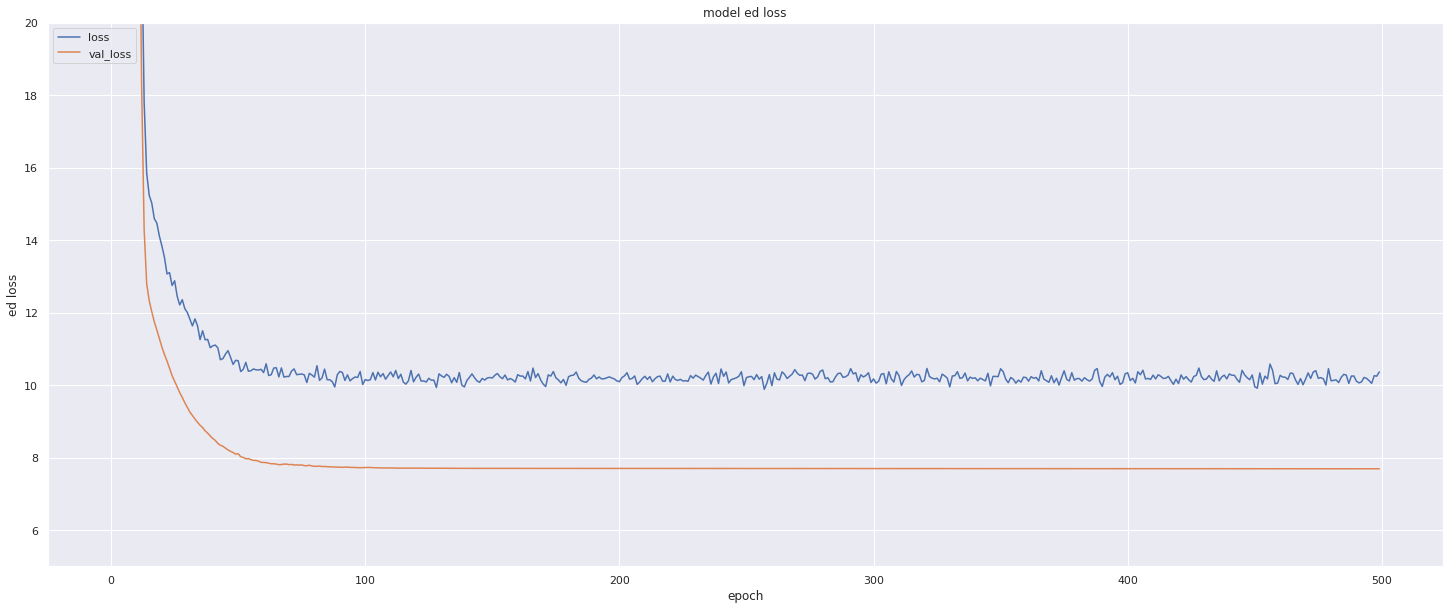

In [111]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_toe.history['loss'])
plt.plot(history_toe.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_toe_tl.png', bbox_inches = 'tight')

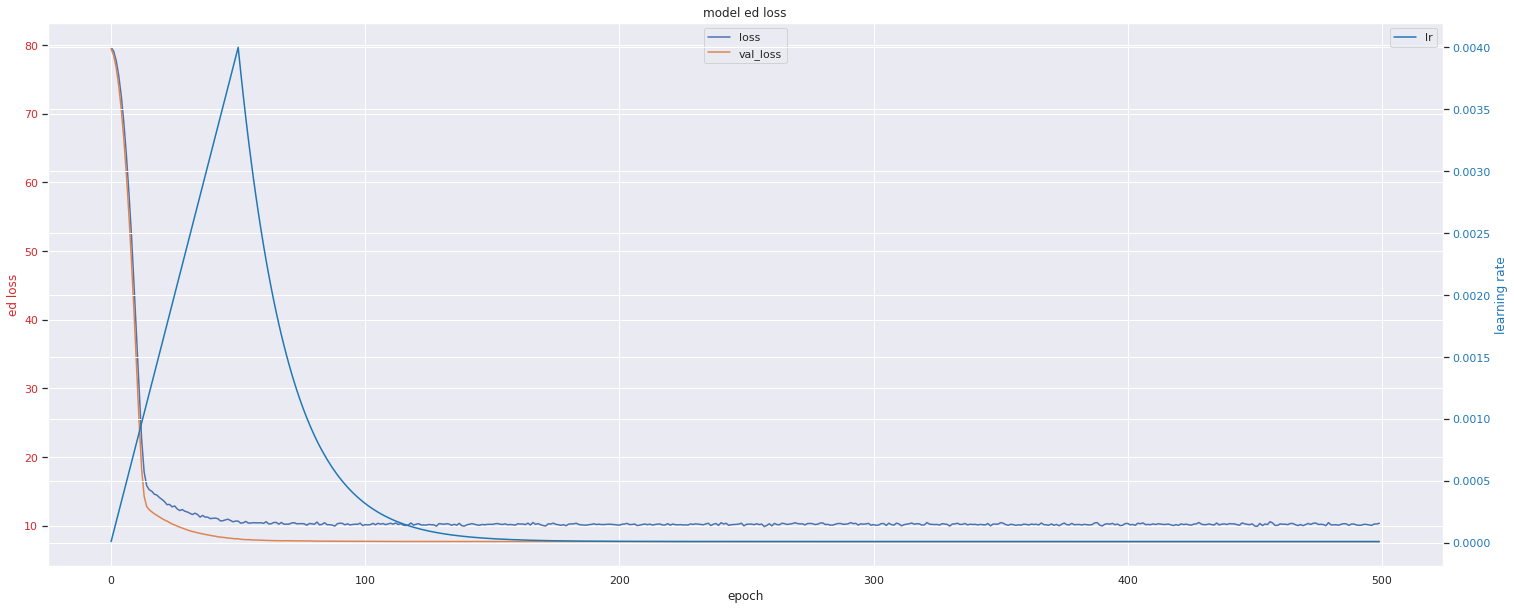

In [112]:
# check the loos the model trained.

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_toe.history['loss'])
ax1.plot(history_toe.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()


# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe.history['val_loss'])
plt.savefig(f'{log_dir_name}_toe_tl_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

## Toe Fine-Tuning

In [113]:
# ep_num = 1000

# def warmup_CosineDecayRestarts(epoch):
#     initial_learning_rate = 1e-5
#     first_decay_steps = 500
    
#     lr_decayed_fn = (
#       tf.keras.optimizers.schedules.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps))
        
#     # warm up
#     step_size = 25 # currently best for foot pp
#     max_lr = initial_learning_rate #0.01 # currently best for foot pp
#     base_lr = 1e-8 # 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 50
#     lr_sus_ep  = 0
#     lr_decay   = 0.5
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
#     else:
#         lr = lr_decayed_fn(epoch)

#     return lr


# ep_num_transf = 500
# rng = [i for i in range(ep_num_transf)]
# y = [warmup_CosineDecayRestarts(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

In [114]:
# # clr3
# # warm up 10% of epoch: it can reduce fall in local min in inital steps.


# ep_num = 1000



# def clr3(epoch):
    
    
#     step_size = 25 # currently best for foot pp
#     max_lr = 0.01 # currently best for foot pp
#     base_lr = 1e-6 # 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.5

#     iterations = epoch
#     cycle = np.floor(1+iterations/(2*step_size))
#     x = np.abs(iterations/step_size - 2*cycle + 1)
#     lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
#     #todo: boost the lr at initial setps.
# #     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
# #     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
# #     lr = initial_lr(epoch)
#     #todo: boost the lr at fist step_size.
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
#     decay = ((epoch+1)/ep_num)
#     base_part = 1.001 #1.1
# #     print(decay)
#     return lr * (base_part-decay) * lr_decay # supressed the lr!


# rng = [i for i in range(ep_num)]
# y = [clr3(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

In [115]:
# """dump lr lower e5
# """
# ep_num_transf = 500



# def lrdump_lower_e5(epoch):
    
#     #step_size = 100
#     lr_max = 0.0004
#     lr_min = 0.000001
#     lr_start = 0.000001

#     lr_init_ep = 0
#     lr_ramp_ep = 50
#     lr_sus_ep  = 0 #10
#     lr_decay   = 0.95

    
#     # warm up
#     if epoch < lr_init_ep:
#         lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
#     elif lr_init_ep -1 < epoch < lr_ramp_ep:
#         lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

#     elif epoch < lr_ramp_ep + lr_sus_ep:
#         lr = lr_max

#     else:
#         lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

#     return lr

# rng = [i for i in range(ep_num_transf)]
# y = [lrdump(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

In [116]:
print('{} ~ {}'.format(min(y), max(y)))

1e-05 ~ 0.004


In [117]:
# """lr from kaggle leaf"""
# ep_num = 1000



# def lrfn2(epoch):
    
#     lr_start   = 0.000005
#     # lr_max     = 0.00000125 * strategy.num_replicas_in_sync * BATCH_SIZE
#     lr_max     = 0.001
#     lr_min     = 0.000001
#     lr_ramp_ep = 50
#     lr_sus_ep  = 20
#     lr_decay   = 0.95


#     if epoch < lr_ramp_ep:
#         lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

#     elif epoch < lr_ramp_ep + lr_sus_ep:
#         lr = lr_max

#     else:
#         lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

#     return lr



# rng = [i for i in range(ep_num)]
# y = [lrfn2(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

In [118]:
print('{} ~ {}'.format(min(y), max(y)))

1e-05 ~ 0.004


In [119]:
def unfreeze_model(model, base_model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.





#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True


#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166 
#

    # Set All layers trainable first
    #model.trainable = True #範例似乎是指 base_model.trainable = True 而不是新建model！！！！！！(2021-11-08)
    base_model.trainable = True
    
    
    
    # Then, set layers NOT trainable below specific layer.
#     set_trainable = False
#     for layer in model.layers:
#         if layer.name == 'block5b_expand_conv': 
#             set_trainable = True
#         if set_trainable:
#             layer.trainable = True
#         else:
#             layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [120]:
# unfreeze for finetune the toe model  
unfreeze_model(model_toe,base_model)

In [121]:
count_model_trainOrNot_layers(model_toe)

tt: 5, nt:0, total layers:5


In [122]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=50), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(lrdump),# lrdump_lower_e5 warmup_CosineDecayRestarts clr3 lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp
    PrintLRtoe()
]

In [123]:
%%time


ep_num = ep_num_transf

# fit the model on all data
history_toe_finetune = model_toe.fit(train_ds_pre_toe_s, 
                      verbose=1, 
                      epochs=ep_num, 
                      validation_data=valid_ds_pre_toe_s, 
                      callbacks=callbacks)#, validation_split=0.1)

Epoch 1/500

[20211111-1419-24] Learning rate for epoch 1 is 9.999999747378752e-06
30/30 [==============================] - 34s 839ms/step - loss: 9.9231 - val_loss: 7.2440

Epoch 00001: val_loss improved from 7.69066 to 7.24399, saving model to ./20211111-141327/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 2/500

[20211111-1419-58] Learning rate for epoch 2 is 8.97999998414889e-05
30/30 [==============================] - 2s 63ms/step - loss: 9.4302 - val_loss: 6.2468

Epoch 00002: val_loss improved from 7.24399 to 6.24683, saving model to ./20211111-141327/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
Epoch 3/500

[20211111-1420-00] Learning rate for epoch 3 is 0.00016959999629762024
30/30 [==============================] - 6s 210ms/step - loss: 9.0355 - val_loss: 6.5712

Epoch 00003: val_loss did not improve from 6.24683
Epoch 4/500

[20211111-1420-07] Learning rate for epoch 4 is 0.0002494000073056668
30/30 [==============================] - 2s 64ms/step - loss: 8.4998 - val_

[2021-11-10] Check FT only
for test only fine tune without transfer learning.
it seems the mED result is positive!

* patinet 50

FT only
    Epoch 00196: val_loss did not improve from 1.63635
    Wall time: 4min 28s

    Epoch 00254: val_loss did not improve from 1.62334
    Wall time: 5min 23s

Check TL + FT

    TL 步數不夠長
    Epoch 00500: val_loss improved from 7.93362 to 7.93355, saving model to ./20211110-145618/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
    Wall time: 3min 38s

    Epoch 00341: val_loss did not improve from 1.39581
    Wall time: 6min 46s

    TL 步數不夠長
    Epoch 00500: val_loss did not improve from 7.91242
    Wall time: 3min 32s

    Epoch 00080: val_loss did not improve from 2.79270 (somehow it stop early this time)
    Wall time: 2min 12s



    [20210225-1426-28] Learning rate for epoch 240 is 0.0016744130989536643
    Epoch 240/1000
    17/17 [==============================] - ETA: 0s - loss: 6.0727
    Epoch 00240: val_loss did not improve from 5.58202
    17/17 [==============================] - 1s 45ms/step - loss: 6.0727 - val_loss: 6.0411
    
    
    [2021-11-02 1504]  RTX 2080 Ti 
    速度慢約10ms/step但主要是噪音無法在辦公室訓練，寫好後開任務容器直接跑圖收結果回來。(註：任務容器仍沒有選用客製化映像檔的功能，對tf25odocr環境建立會很棘手！)
    RTX 2080 Ti Temp 63~66  GPU-util ~63% (風扇噪音與熱氣無法放辦公室使用) ~75, 92% 後來訓練
    
    Epoch 00323: val_loss did not improve from 5.70558
    Epoch 324/1000

    [20211102-0757-50] Learning rate for epoch 324 is 0.003114226972684264
    17/17 [==============================] - 3s 55ms/step - loss: 6.2408 - val_loss: 6.4956
    
    #每次shuffle要固定種子 df.sample(frac=1, random_state=42).reset_index(drop=True)
    Epoch 00132: val_loss did not improve from 5.85424
    Epoch 133/1000

    [20211103-0047-39] Learning rate for epoch 133 is 0.0031249215826392174
    17/17 [==============================] - 1s 49ms/step - loss: 6.1173 - val_loss: 6.9323

    Epoch 00133: val_loss did not improve from 5.85424
    CPU times: user 2min 8s, sys: 5.38 s, total: 2min 13s
    Wall time: 2min 14s

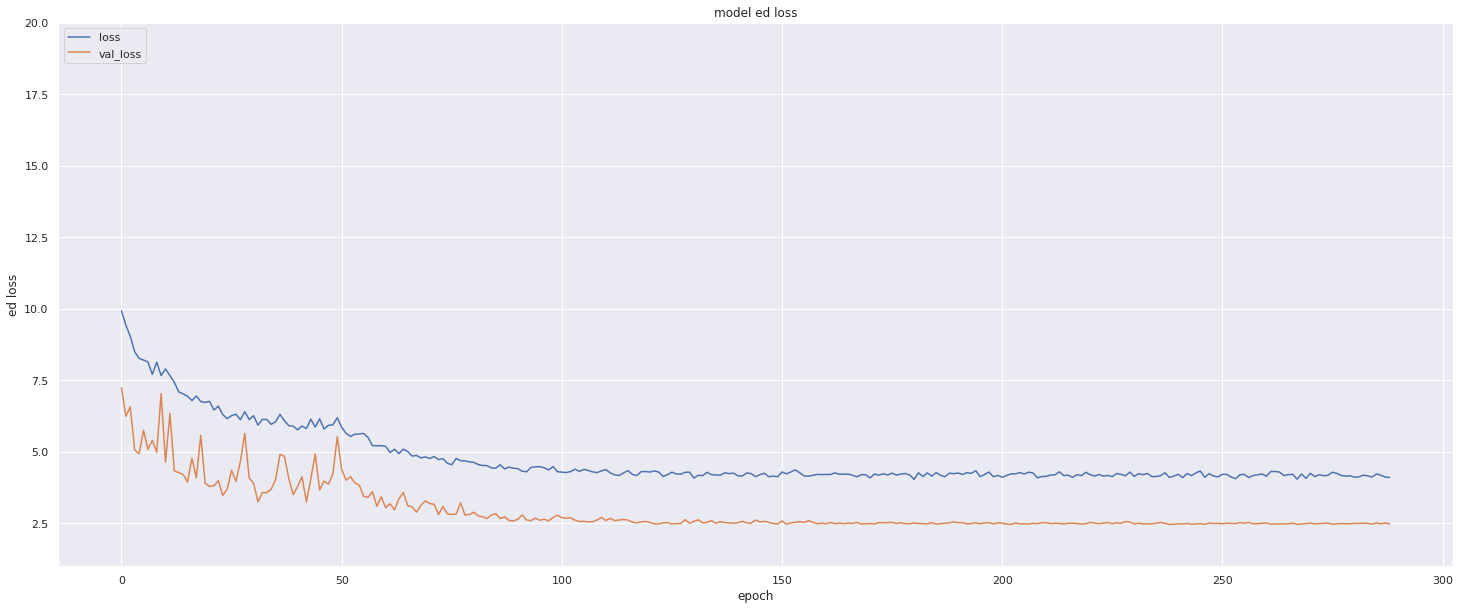

In [124]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_toe_finetune.history['loss'])
plt.plot(history_toe_finetune.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(1, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_toe_ft.png', bbox_inches = 'tight')

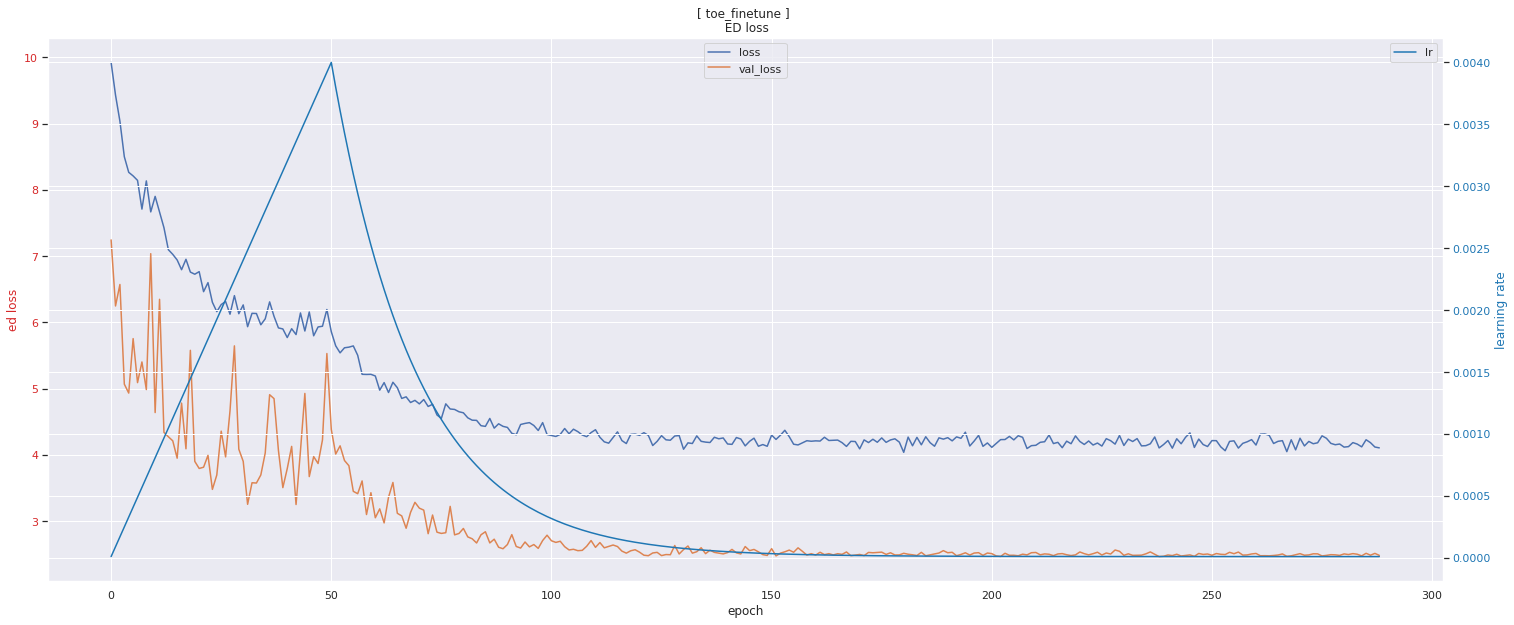

In [125]:
# check the loos the model trained.

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ toe_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_toe_finetune.history['loss'])
ax1.plot(history_toe_finetune.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe_finetune.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe_finetune.history['val_loss'])
plt.savefig(f'{log_dir_name}_toe_ft_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [126]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe_finetune.history['val_loss'])

vl, ep 

(2.463940143585205, 238)

In [127]:
def print_valloss(his_v_l):
     
    print(f'val_loss: {np.min(his_v_l)} at epoch {np.argmin(his_v_l)}.')
    
print_valloss(history_toe_finetune.history['val_loss'])

val_loss: 2.463940143585205 at epoch 238.


In [128]:
# from tensorflow.keras.utils import plot_model
# plot_model(model_toe, to_file='model_toe_conv_layer_blocks.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model_toe_conv_layer_blocks.png') 

## Check the mean-Euclidean Distance of test data

may modify the ed-loss function

In [129]:
# # mean ed-loss == mean ed of test data.
# model_toe.evaluate(valid_ds_pre_toe_s)

In [130]:
# model_toe.evaluate(test_ds_pre_toe_s)
# model_heel.evaluate(test_ds_pre_heel_s)

# Heel 

### Transfer

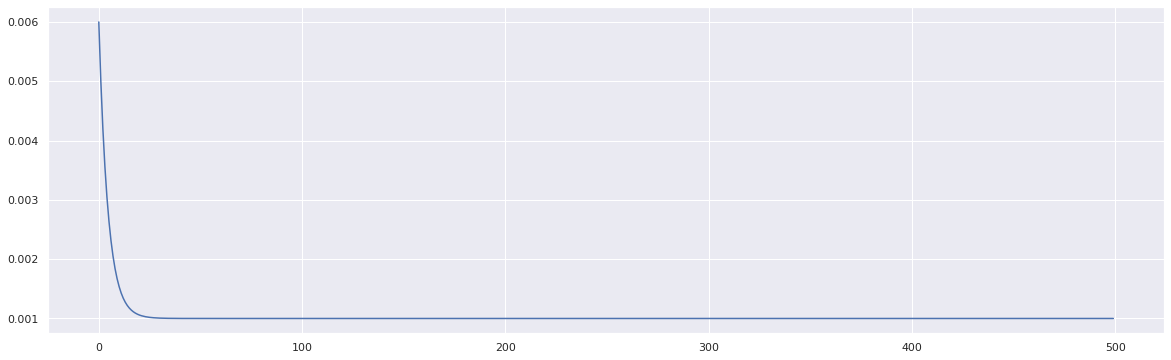

In [131]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 0
    lr_sus_ep  = 0
    lr_decay   = 0.8

    if lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [132]:
print('{} ~ {}'.format(min(y), max(y)))

0.001 ~ 0.006


In [133]:
"""

"""
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, 
#                                                           factor=0.5, 
#                                                           patience=15, 
#                                                           verbose=1, 
#                                                           mode='auto', 
#                                                           #min_delta=0.0001, 
#                                                           cooldown=5, 
#                                                           #min_lr=1e-12
#                                                          )

'\n\n'

In [134]:
def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
th = 'heel'

print(get_best_model_name(th))

best_model_name = get_best_model_name(th)


best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)

./20211111-141327/heel_EfficientNetB0_bs64_w120_best_val_loss.h5
best_model_name: ./20211111-141327/heel_EfficientNetB0_bs64_w120_best_val_loss.h5


In [135]:
logdir = log_dir_name + "/logs/heel/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [136]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size ot ep_num
    tf.keras.callbacks.LearningRateScheduler(lrdump),#,clr2_heel  lrfn2_heel decay or lrfn or lrfn2. clr
#     lr_reduceonplateau,
    PrintLRheel()
]

In [137]:
# create Heel-tf model
top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.4 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2
with strategy.scope():
    model_heel,base_model = build_efn_model(outputnum, top_dropout_rate, drop_connect_rate)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [138]:
count_model_trainOrNot_layers(model_heel)

tt: 4, nt:1, total layers:5


In [139]:
%%time

# fit the model on all data
history_heel = model_heel.fit(train_ds_pre_heel_s, 
                      verbose=1, 
                      epochs=ep_num_transf, 
                      validation_data=valid_ds_pre_heel_s, 
                      callbacks=callbacks)

Epoch 1/500
30/30 [==============================] - 15s 294ms/step - loss: 83.6529 - val_loss: 53.9313

Epoch 00001: val_loss improved from inf to 53.93132, saving model to ./20211111-141327/heel_EfficientNetB0_bs64_w120_best_val_loss.h5

[20211111-1430-03] Learning rate for epoch 1 is 0.006000000052154064
Epoch 2/500
30/30 [==============================] - 1s 21ms/step - loss: 38.7446 - val_loss: 25.6070

Epoch 00002: val_loss improved from 53.93132 to 25.60703, saving model to ./20211111-141327/heel_EfficientNetB0_bs64_w120_best_val_loss.h5

[20211111-1430-03] Learning rate for epoch 2 is 0.004999999888241291
Epoch 3/500
30/30 [==============================] - 4s 152ms/step - loss: 24.2216 - val_loss: 22.0819

Epoch 00003: val_loss improved from 25.60703 to 22.08191, saving model to ./20211111-141327/heel_EfficientNetB0_bs64_w120_best_val_loss.h5

[20211111-1430-08] Learning rate for epoch 3 is 0.00419999985024333
Epoch 4/500
30/30 [==============================] - 1s 21ms/step -

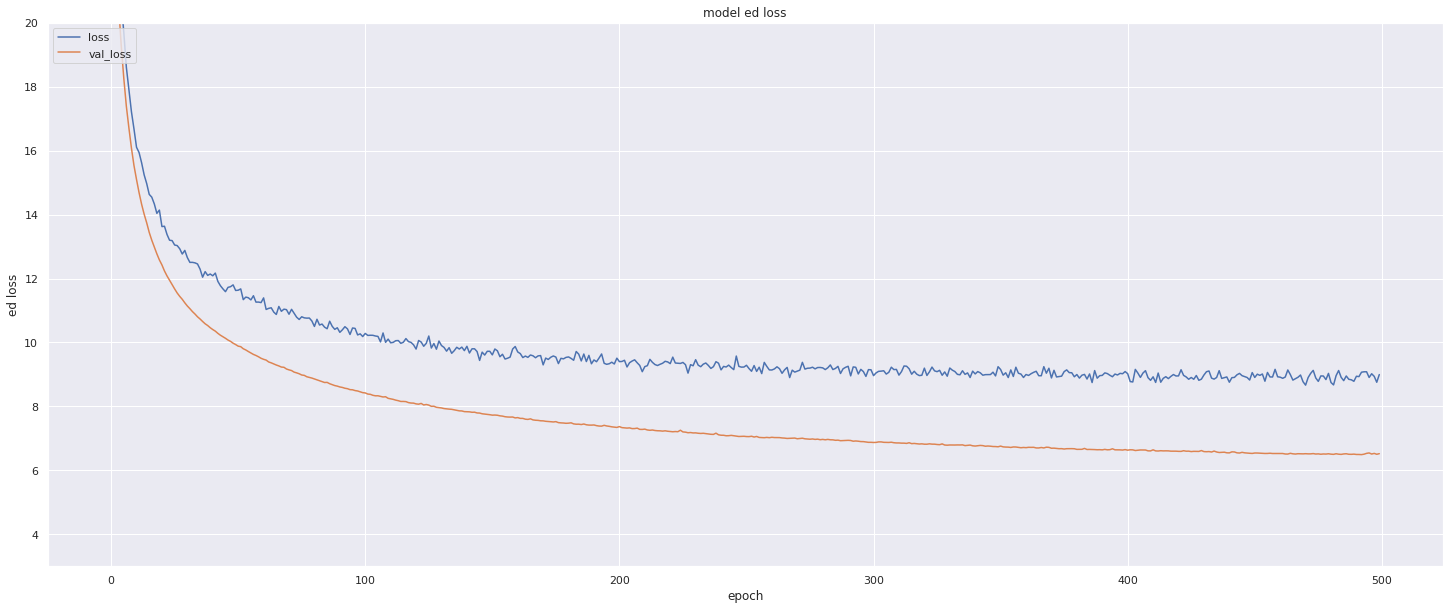

In [140]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_heel.history['loss'])
plt.plot(history_heel.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(3, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_heel_tl', bbox_inches = 'tight')

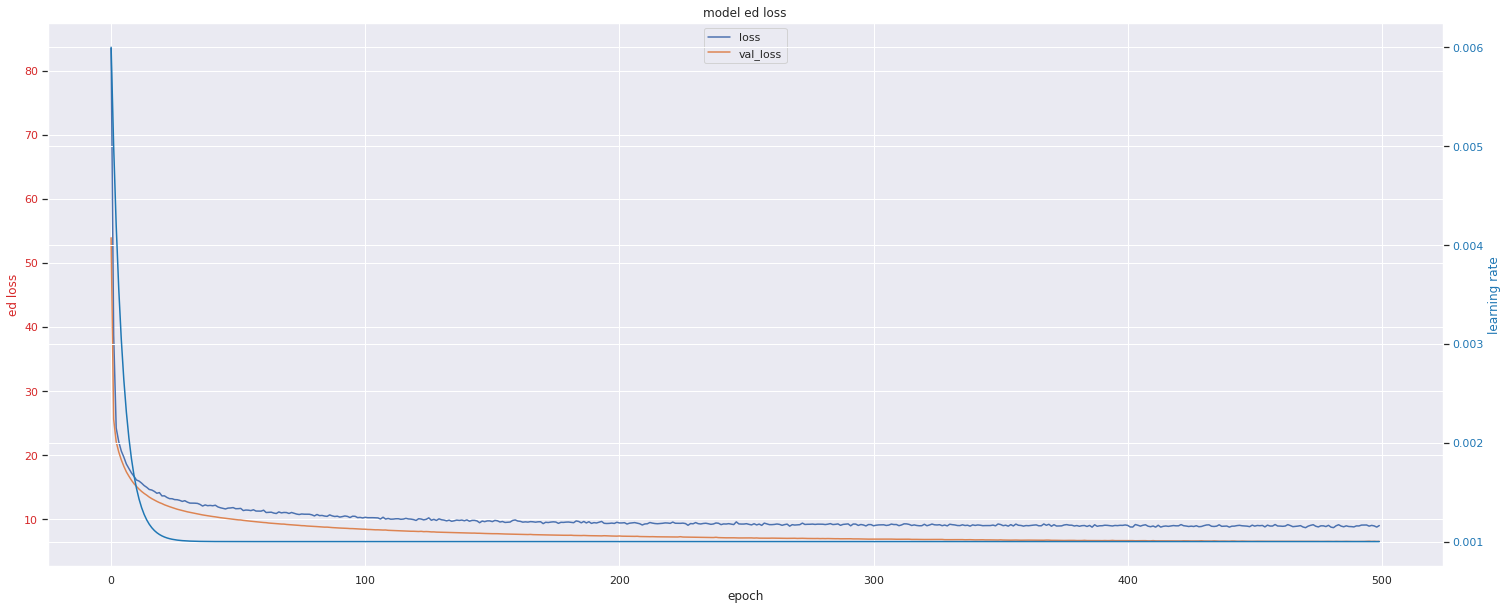

In [141]:
# check the loos the model trained.


# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_heel.history['loss'])
ax1.plot(history_heel.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel.history['val_loss'])
plt.savefig(f'{log_dir_name}_heel_tl_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [142]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel.history['val_loss'])

vl, ep

(6.492372035980225, 492)

## Heel Fine-Tuning

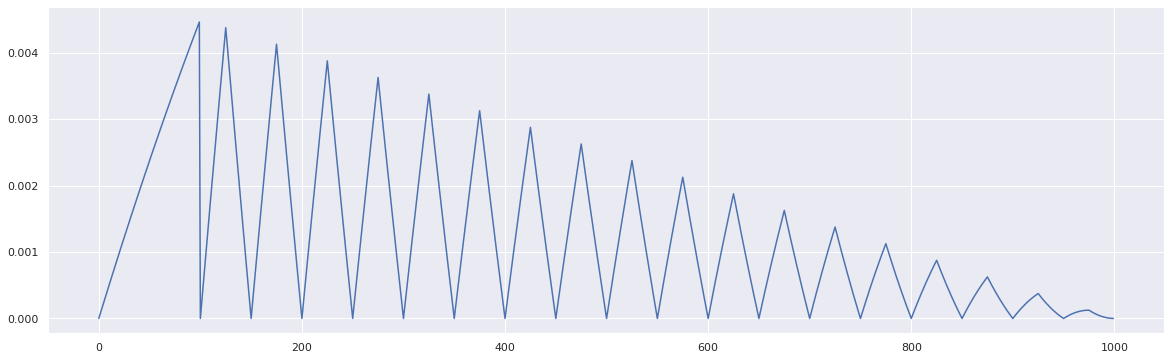

In [143]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7
    
#     step_size = 25 # currently best for foot pp
#     max_lr = 0.01 # currently best for foot pp
#     base_lr = 1e-8 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))# 1~20 range.
    x = np.abs(iterations/step_size - 2*cycle + 1) # 1~0,repeat 20 cycle.
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))

    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = base_lr + (((max_lr - base_lr) / lr_ramp_ep) * epoch)
    
#     # decay
#     if epoch > lr_ramp_ep:
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#         lr = lr * (base_part-decay)

    return lr * (base_part-decay) * lr_decay # supressed the lr! in fact, it will reduce new lr to 1/2 ratio.


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [144]:
# 4.999999999999993e-08 ~ 0.00891990901   # original lr with epoch decay.
# 2.4999999999999966e-08 ~ 0.004459954505 # supressed the lr!

In [145]:
print('{} ~ {}'.format(min(y), max(y)))

2.4999999999999966e-08 ~ 0.004459954505


In [146]:
# unfreeze for finetune the toe model  
unfreeze_model(model_heel,base_model)

In [147]:
count_model_trainOrNot_layers(model_heel)

tt: 5, nt:0, total layers:5


In [148]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=20), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(clr3),#clr3 lrdump, decay or lrfn or lrfn2. clr
    PrintLRheel()
]

In [149]:
%%time

# fit the model on all data
history_heel_finetune = model_heel.fit(train_ds_pre_heel_s, 
                      verbose=1, 
                      epochs=ep_num, 
                      validation_data=valid_ds_pre_heel_s, 
                      callbacks=callbacks)

Epoch 1/1000
30/30 [==============================] - 34s 757ms/step - loss: 8.8068 - val_loss: 6.3755

Epoch 00001: val_loss improved from 6.49237 to 6.37548, saving model to ./20211111-141327/heel_EfficientNetB0_bs64_w120_best_val_loss.h5

[20211111-1437-53] Learning rate for epoch 1 is 4.999999987376214e-07
Epoch 2/1000
30/30 [==============================] - 2s 67ms/step - loss: 7.8820 - val_loss: 4.2159

Epoch 00002: val_loss improved from 6.37548 to 4.21592, saving model to ./20211111-141327/heel_EfficientNetB0_bs64_w120_best_val_loss.h5

[20211111-1437-56] Learning rate for epoch 2 is 5.044450517743826e-05
Epoch 3/1000
30/30 [==============================] - 6s 194ms/step - loss: 7.0096 - val_loss: 4.3308

Epoch 00003: val_loss did not improve from 4.21592

[20211111-1438-02] Learning rate for epoch 3 is 0.00010028902033809572
Epoch 4/1000
30/30 [==============================] - 2s 65ms/step - loss: 6.5936 - val_loss: 5.5461

Epoch 00004: val_loss did not improve from 4.21592

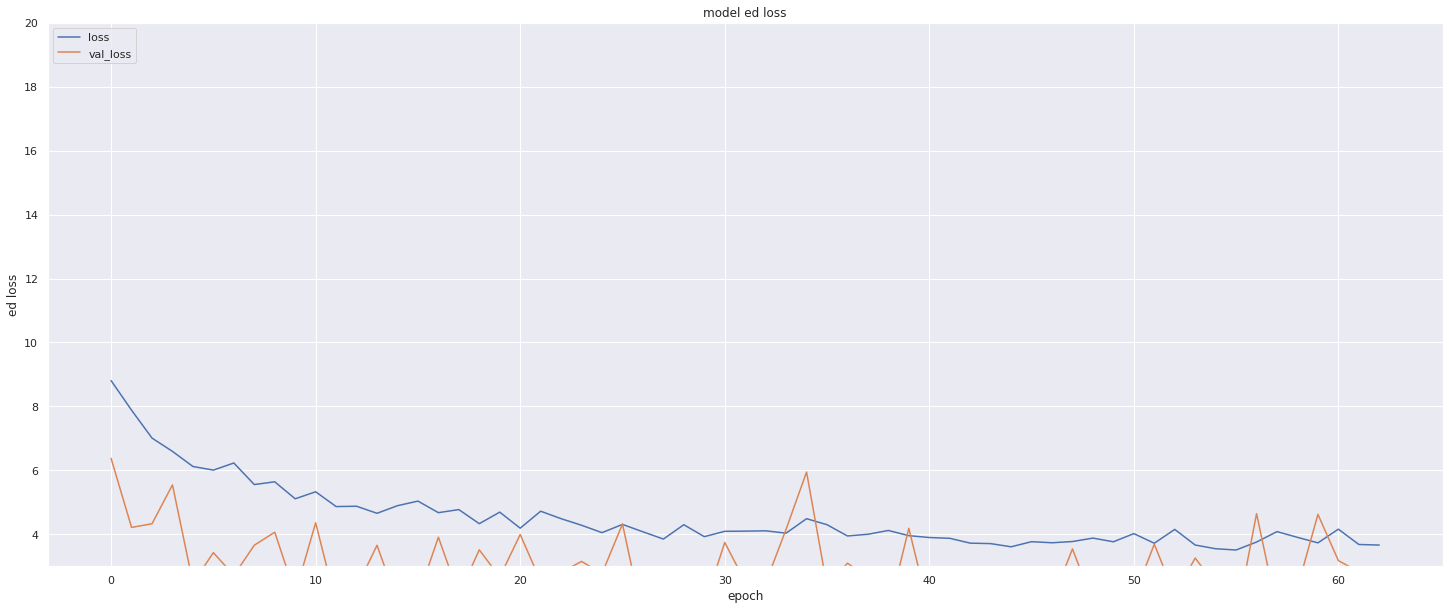

In [150]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_heel_finetune.history['loss'])
plt.plot(history_heel_finetune.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(3, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_heel_ft.png', bbox_inches = 'tight')

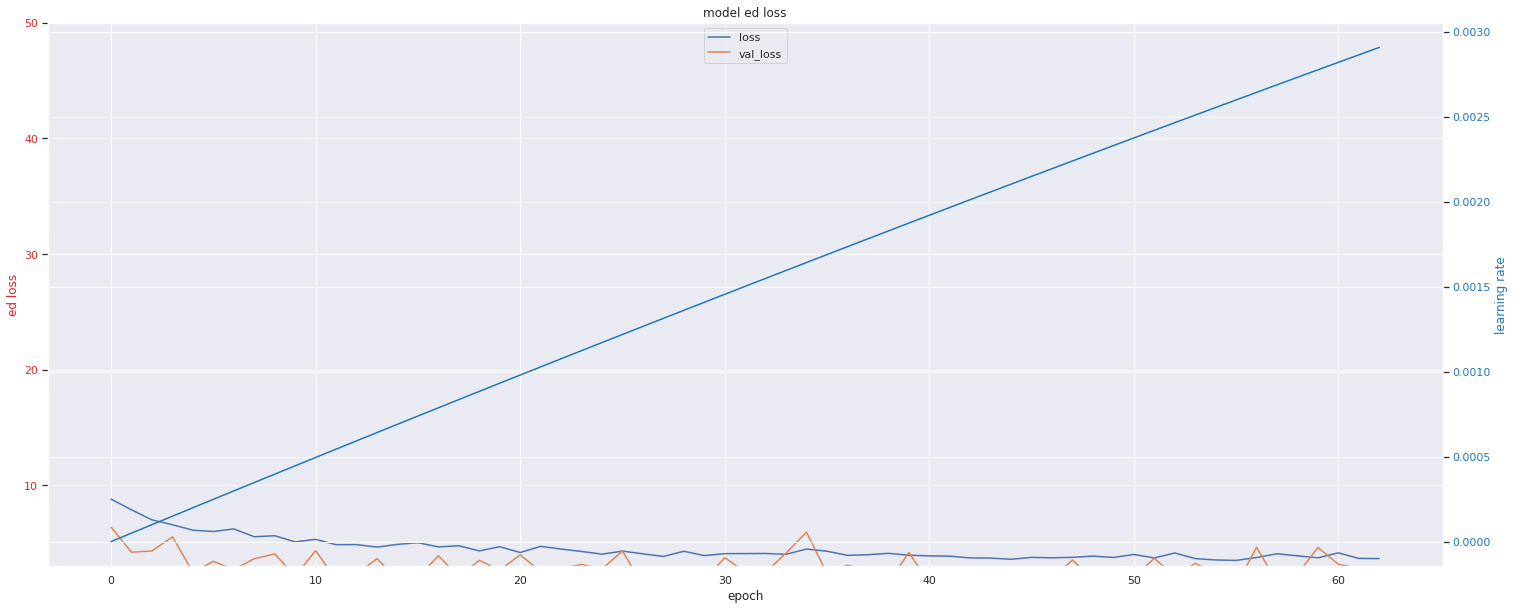

In [151]:
# check the loos the model trained.


# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color), ax1.set_ylim(3, 50)

ax1.plot(history_heel_finetune.history['loss'])
ax1.plot(history_heel_finetune.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel_finetune.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel_finetune.history['val_loss'])
plt.savefig(f'{log_dir_name}_heel_ft_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [152]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel_finetune.history['val_loss'])

In [153]:
vl, ep 

(1.29270339012146, 42)

In [154]:
def print_valloss(his_v_l):
     
    print(f'val_loss: {np.min(his_v_l)} at epoch {np.argmin(his_v_l)}.')
    
print_valloss(history_heel_finetune.history['val_loss'])

val_loss: 1.29270339012146 at epoch 42.


In [155]:
# mean ed-loss == mean ed of test data.
model_heel.evaluate(valid_ds_pre_heel_s)

8/8 [==============================] - 0s 12ms/step - loss: 2.3111


2.3110713958740234

In [156]:
# 這是最後模型去推論結果，不是中斷前的best model!

## Show predictions

In [157]:
# %%time
# # inference all val_ds
# predictions = model.predict(valid_ds_pre_toe_s)

In [158]:
# predictions.shape

In [159]:
# predictions[:5]

In [160]:
# %%time

# # inference bs by bs of val_ds #model.predict()#一次做完即可不用分batch
# image_batch, label_batch = valid_ds_pre_heel_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)

In [161]:
# image_batch.shape

In [162]:
# pred.shape

In [163]:
# pred[:5]

In [164]:
# label_batch[:5]

In [165]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [166]:
# neg[:5]

In [167]:
# neg.mean()#所有x,y平均

In [168]:
# neg.mean(axis=0)#所有x 所有y個別平均

In [169]:
# neg.mean(axis=1)#左x右y相加的平均

In [170]:
# np.median(neg)#中位數

In [171]:
# neg.min(axis=0)

In [172]:
# neg.max(axis=0)

In [173]:
# model.metrics_names

## show pp pred

* we can switch toe/hell by comment it

### Baseline Simple2D model

In [174]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [175]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# # pred = model_toe.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=4)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=4)

### EFN Toe

In [176]:
it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

CPU times: user 3.13 s, sys: 20.2 ms, total: 3.15 s
Wall time: 3.12 s


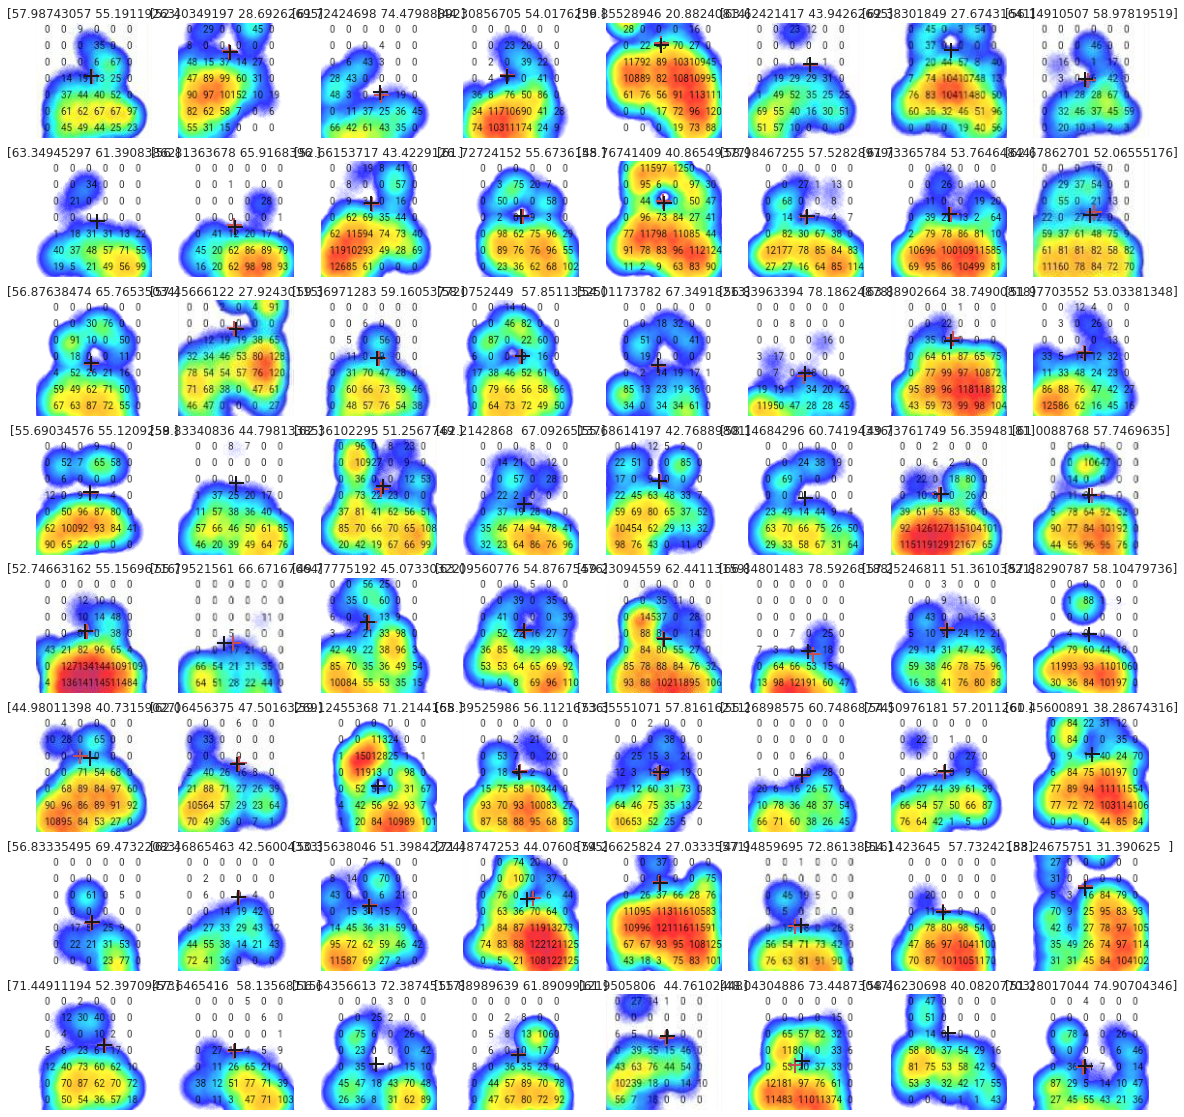

In [177]:
%%time

# image_batch, label_batch = next(valid_ds_pre_toe_s)

image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# image_batch, label_batch = next(it_valid_ds_pre_heel_s)


pred = model_toe.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

plt.figure(figsize=(20, 20))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(image_batch[i])
    plt.title(label_batch[i].numpy())
    plt.axis("off")
    
    # note: y_offset_toe for ds image
    
    #ground truth
    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

    #pred
    plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [178]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [179]:
# np.abs(neg)[:5]

In [180]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2D

In [181]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

### EFN Heel

In [182]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

CPU times: user 3.31 s, sys: 36 ms, total: 3.34 s
Wall time: 4.32 s


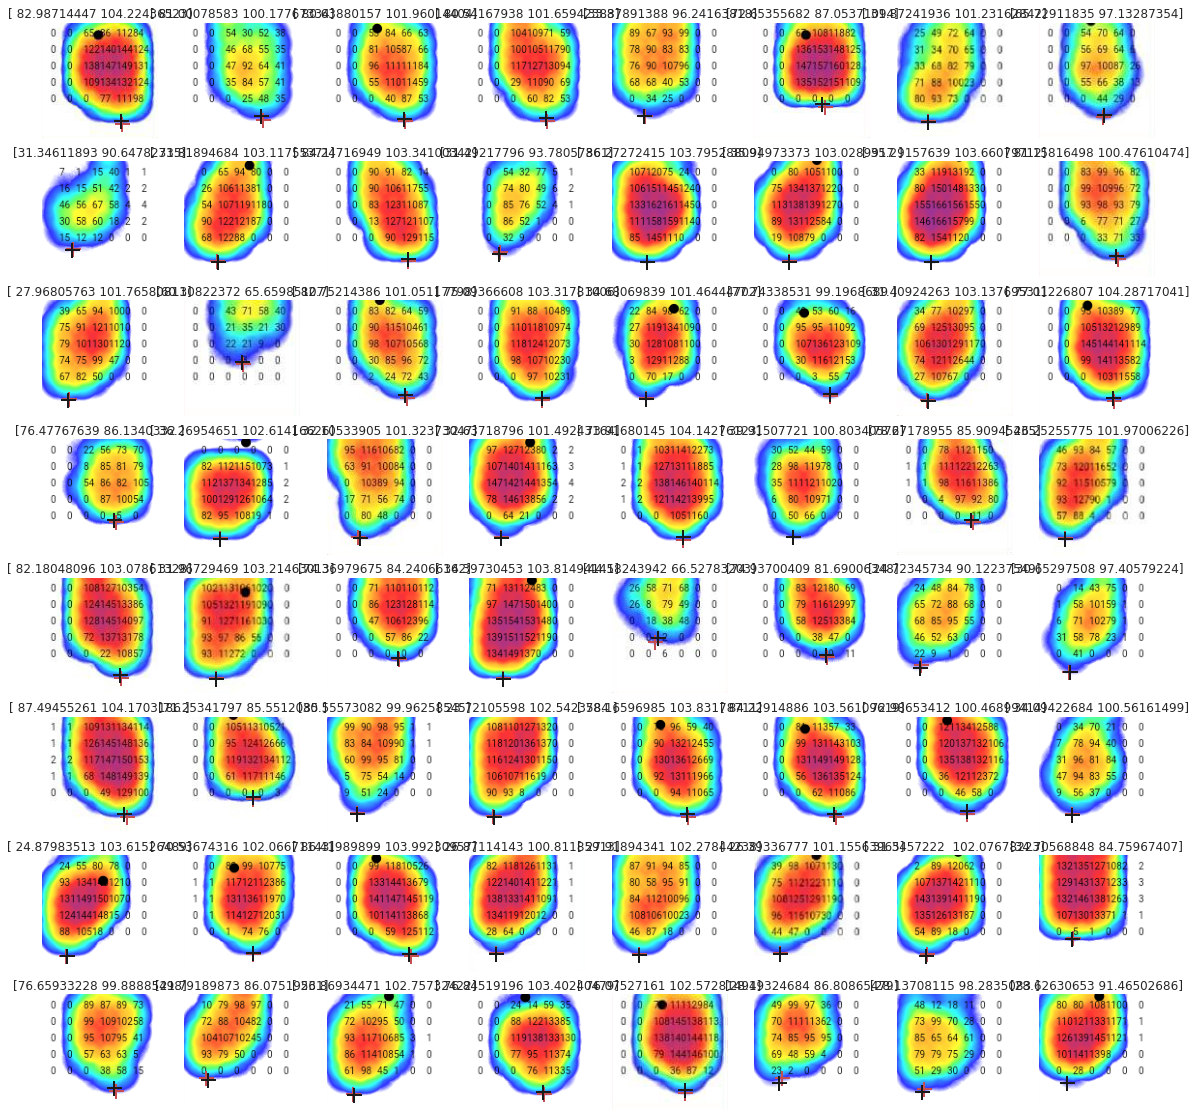

In [183]:
%%time

# image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
image_batch, label_batch = next(it_valid_ds_pre_heel_s)


pred = model_heel.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

plt.figure(figsize=(20, 20))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(image_batch[i])
    plt.title(label_batch[i].numpy())
    plt.axis("off")
    
    # note: y_offset_toe for ds image
    
    #ground truth
    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

    #pred
    plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [184]:
# pred[:5]

In [185]:
# label_batch[:5]

In [186]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:10]

In [187]:
# np.abs(neg)[:10]

In [188]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2d

In [189]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

# Merg Toe/Heel model and predict the Test data at once

### Create TEST DS

In [190]:
# ts = 'test_submission.csv'
# df_ts = pd.read_csv(ts)
# df_ts.head(5)

##### [HAL-Labeling]

In [191]:
# [HAL-Labeling]

ts = 'annotation_1345_good.csv'
df_ts = pd.read_csv(ts)
df_ts.head(5)


images  x1   y1  x2   y2
0  image_0001.png  55  136  75  383
1  image_0002.png  62  139  42  385
2  image_0003.png  47  117  76  368
3  image_0004.png  66  119  37  376
4  image_0005.png  58  147  85  381

In [192]:
df_ts['images']

0       image_0001.png
1       image_0002.png
2       image_0003.png
3       image_0004.png
4       image_0005.png
             ...      
1340    image_6419.jpg
1341    image_6421.jpg
1342    image_6422.jpg
1343    image_6423.jpg
1344    image_6424.jpg
Name: images, Length: 1345, dtype: object

In [193]:
# from dataframe
list_ds_test = tf.data.Dataset.from_tensor_slices(df_ts['images'])


In [194]:
len(list_ds_test)#.shape() #take(1)

1345

In [195]:
# check The type specification of an element of this dataset.
list_ds_test.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [196]:
for f in list_ds_test.take(5):
    print(f'take test sample: {f}')

take test sample: b'image_0001.png'
take test sample: b'image_0002.png'
take test sample: b'image_0003.png'
take test sample: b'image_0004.png'
take test sample: b'image_0005.png'


### TEST DS: Process TEST path to image tensor

In [197]:
## TEST-DS: re-used from train/val-ds

# im_test = 'test_images/'

# [HAL-Labeling] 
im_test = 'train/images/'

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe_test(img)
    return img, file_name

#
# map list to ds, Heel part.
#

def decode_crop_png_heel_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel_test(img)
    return img, file_name


#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [198]:
# TEST Toe ds
test_ds_map_toe = list_ds_test.map(process_path_toe_test, num_parallel_calls=AUTOTUNE)

# TEST Heel ds
test_ds_map_heel = list_ds_test.map(process_path_heel_test, num_parallel_calls=AUTOTUNE)

In [199]:
for img, file_name in test_ds_map_toe.take(5):
    print(f'take sample: {img.shape} {file_name}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

take sample: (120, 120, 3) b'image_0001.png'
take sample: (120, 120, 3) b'image_0002.png'
take sample: (120, 120, 3) b'image_0003.png'
take sample: (120, 120, 3) b'image_0004.png'
take sample: (120, 120, 3) b'image_0005.png'


### prepare TEST_ds_pre

In [200]:
def configure_for_performance_cache_test(ds, cache=True):

    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
#     if augment:
# #         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
# #         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(1000)# 1k for foot test images #MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    return ds


In [201]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# TEST Toe ds_pre
test_ds_pre_toe = configure_for_performance_cache_test(test_ds_map_toe)

# TEST Heel ds_pre
test_ds_pre_heel = configure_for_performance_cache_test(test_ds_map_heel)

Check cache in memory:Y True
Check cache in memory:Y True


## Predict test (abandon)

### Toe model

In [202]:
# model_toe

In [203]:
# %%time
# # inference all test_ds once
# predictions_toe = model_toe.predict(test_ds_pre_toe)
# predictions_toe.shape

In [204]:
# predictions_toe

### Offset Toe

In [205]:
# predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe
# predictions_toe

### Heel model

In [206]:
# %%time
# # inference all test_ds once
# predictions_heel = model_heel.predict(test_ds_pre_heel)
# predictions_heel.shape

In [207]:
# predictions_heel

### Offset Heel

In [208]:
# predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel
# predictions_heel

### Merge toe/hell pred

In [209]:
# predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
# predictions_th.shape

In [210]:
# predictions_th.shape

In [211]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [212]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [213]:
# predictions_merge.take(0)

In [214]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [215]:
# df_submission.head(5)

In [216]:
# df_submission.to_csv('submission.csv', index=False)

# Load Best-model

In [217]:
# if models are in last time frame
best_model_toe_name = get_best_model_name('toe')
best_model_heel_name = get_best_model_name('heel')

# # if toe/heel are in different time frame
# best_model_toe_name = '20210118-212454/toe_EfficientNetB0_bs64_w120_best_val_loss.h5'#6.3318 @e393
# best_model_heel_name = '20210122-084854/heel_EfficientNetB0_bs64_w120_best_val_loss.h5'#3.27979@152




print(best_model_toe_name)
print(best_model_heel_name)
# log_dir_name + '/' + 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'

best_model_toe = tf.keras.models.load_model(best_model_toe_name,compile=False)
best_model_heel = tf.keras.models.load_model(best_model_heel_name,compile=False)

./20211111-141327/toe_EfficientNetB0_bs64_w120_best_val_loss.h5
./20211111-141327/heel_EfficientNetB0_bs64_w120_best_val_loss.h5


### compile the model separately afterwards. to load model with custom loss function

* https://github.com/tensorflow/tensorflow/issues/32348

In [218]:
best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])

# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

    

In [219]:
%%time
# inference all test_ds once
predictions_toe = best_model_toe.predict(test_ds_pre_toe)
predictions_toe.shape

CPU times: user 4.59 s, sys: 613 ms, total: 5.2 s
Wall time: 6.5 s


(1345, 2)

### Offset Toe

In [220]:
predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe

# for [0,1]
# predictions_toe[:,0] = predictions_toe[:,0]*120
# predictions_toe[:,1] = predictions_toe[:,1]*120 + y_offset_toe

# # for [-1,1]
# # for re-scale back xy 
# # return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# # return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] 
# predictions_toe[:,0] = (predictions_toe[:,0]*60)+60
# predictions_toe[:,1] = (predictions_toe[:,1]*60)+60 + y_offset_toe

predictions_toe

array([[ 54.605366, 134.80698 ],
       [ 61.559025, 138.93442 ],
       [ 46.621914, 117.49681 ],
       ...,
       [ 49.482117, 154.59497 ],
       [ 64.12724 , 148.28275 ],
       [ 47.05128 , 147.27925 ]], dtype=float32)

In [221]:
%%time
# inference all test_ds once
predictions_heel = best_model_heel.predict(test_ds_pre_heel)
predictions_heel.shape

CPU times: user 2.85 s, sys: 192 ms, total: 3.04 s
Wall time: 2.11 s


(1345, 2)

### Offset Heel

In [222]:
predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel

# for [0,1]
# predictions_heel[:,0] = predictions_heel[:,0]*120
# predictions_heel[:,1] = predictions_heel[:,1]*120 + y_offset_heel

# # for [-1,1]
# predictions_heel[:,0] = (predictions_heel[:,0]*60)+60
# predictions_heel[:,1] = (predictions_heel[:,1]*60)+60 + y_offset_heel

predictions_heel

array([[ 75.13822 , 383.32764 ],
       [ 39.87411 , 383.2758  ],
       [ 73.64696 , 366.28305 ],
       ...,
       [ 28.953259, 374.79102 ],
       [ 82.3567  , 382.49155 ],
       [ 30.787455, 382.76096 ]], dtype=float32)

### Merge toe/hell pred

In [223]:
predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
predictions_th.shape

(1345, 4)

In [224]:
images_name = np.expand_dims(df_ts['images'], axis=1)
images_name.shape

(1345, 1)

In [225]:
predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
predictions_merge.shape

(1345, 5)

In [226]:
df_submission = pd.DataFrame(predictions_merge)
df_submission.columns = ['images','x1','y1','x2','y2']

In [227]:
# #fixed random_state rs 42
# submi_name = log_dir_name + '/PT_' + log_dir_name + '_rs42_noAug_df1345_' +'.csv'

# # submi_name = '0000_ft_' + log_dir_name +'.csv'
# # submi_name = 'Bth_clr3_2690_XYnorm[0-1]_' + log_dir_name +'.csv'
# df_submission.to_csv(submi_name, index=False)
# print('Save {} as submission CSV.'.format(submi_name))


# [HAL-Labeling] 

submi_name = log_dir_name + '/HAL-Labeling_' + log_dir_name + '_rs42_noAug_df1345_' +'.csv'
df_submission.to_csv(submi_name, index=False)
print('Save {} as submission CSV.'.format(submi_name))


Save 20211111-141327/HAL-Labeling_20211111-141327_rs42_noAug_df1345_.csv as submission CSV.


In [228]:
# [HAL-Labeling] 

#             ALL with lrdump (warmup 50, NO suspend)     
#             heel with lrdump (drop lr only) + clr3 
#                     Best model's ed of :  EfficientNetB0 20211109-133352 WallTime:  1039.9435215573758
#                     val ED:5.59681 + 3.61883 = 9.21564
#                     Test ED:5.59681 + 3.61883 = 9.21564 (9.2x波動) 目前最佳lr組合

# Save 20211109-133352/HAL-Labeling_20211109-133352_rs42_noAug_df1345_.csv as submission CSV.

    2021-11-03
    重新用無aug訓練結果
    
    0000_ft_20211103-033949.csv 
    ED 5.47334 + 3.55069 = 9.02404 LB 9.4121266 
    
    * 比較1424/1345 noAug對LB差異
    * 證實：使用不刪減標註錯誤的原始資料集，在noAug，相同random_state=42下train/val相同下，具有比資料清洗後更高的LB。這差距應該差不多是當初privte LB 1st的差距(8.1914 <-- 8.3141)。
    20211103-140936/PT_20211103-140936_rs42_noAug_df1345_.csv 
    ED 5.81324 + 3.66716 = 9.4804 LB: 9.3162689
    
    20211103-143247/PT_20211103-143247_rs42_noAug_df1424_.csv (** df1424並未開啟)
    ED:5.73402 + 3.46492 = 9.19894 LB: 9.1828668
    
    
    
    [EfficientNetB0]
    2021-11-05 上面df1424並未開啟
        20211105-101047/PT_20211105-101047_rs42_noAug_df1424_.csv
        ED:6.09531 + 3.5876 = 9.68291 LB: 9.7025955 更差了
        ED:6.25209 + 3.4496 = 9.70169 ??重跑更加差
        ED:6.34336 + 3.52755 = 9.87091 WTF??
        ED:6.0768 + 3.60764 = 9.68444
        ED:6.24145 + 3.37453 = 9.61598
            訓練不穩定！！之前也有過，不清楚原因。
        ED:6.37047 + 3.674 = 10.04447
        
        %reset -f 清除 IPython 中的所有變數 + run: Restart kernal and run all cells
        ED:6.46048 + 3.53942 = 9.9999
        ED:6.21367 + 3.55884 = 9.77251
        ED:6.26749 + 3.65374 = 9.92124 LB: 9.9827463
        
        

        
        
        切回df1345 驗證看看_rs42_noAug_df1345
        ED:5.87471 + 3.55093 = 9.42564
        ED:5.67823 + 3.61991 = 9.29813
        ED:5.75891 + 3.45725 = 9.21615 LB: 9.3887453
        Best model's ed of :  EfficientNetB0 WallTime:  537.3011837955564
        val ED:5.97359 + 3.58608 = 9.55967
        Test ED:6.23453 + 3.67103 = 9.90556
        
        
     貌似120太小，使用複雜的模型反而在虛空漫遊似的，找不到最小值。可以嘗試簡化的模型來驗證。   
    
    [B7]
     val ED:6.066 + 3.74753 = 9.81353
    Test ED:6.48869 + 3.78462 = 10.27331
    
    
    
    [Xception]
        28mins
        val ED:5.99453 + 4.6716 = 10.66613
        Test ED:6.29403 + 4.49941 = 10.79345

    [VGG] not work, kill at first epoch!!!
    
    
    [2021-11-07] (1)Test W/WO Aug. (2) model.trainable=True. (3)Test tl with training=false. (With 1345)
    [2021-11-08]
    
        [B0] org, test/val only, noAug
        Best model's ed of :  EfficientNetB0 WallTime:  983.4519834686071 16.4min
            val ED:5.98883 + 3.46494 = 9.45377
            Test ED:5.98883 + 3.46494 = 9.45377
        Best model's ed of :  EfficientNetB0 WallTime:  588.9569533187896 10.0min
            val ED:5.79862 + 3.54382 = 9.34244
            Test ED:5.79862 + 3.54382 = 9.34244
            
        [B0] org, test/val only, Aug
        Best model's ed of :  EfficientNetB0 WallTime:  2204.2603075709194 36.7min (增加3.5倍時間 僅進步0.05)
            val ED:5.71393 + 3.58175 = 9.29568
            Test ED:5.71393 + 3.58175 = 9.29568
            
            
            
        [B0] org, test/val only, noAug, model.trainable = True (All trainable)
            Best model's ed of :  EfficientNetB0 WallTime:  1071.7707716338336 17.8min
            val ED:5.52118 + 3.53973 = 9.0609
        again>
            Best model's ed of :  EfficientNetB0 WallTime:  1188.2662735395133 19.8min
            val ED:5.56375 + 3.69408 = 9.25783 (波動太大 無法判斷原因參數)

            
        [B0] org, test/val only, Aug, model.trainable = True (All trainable)
            Best model's ed of :  EfficientNetB0 WallTime:  2785.3764121886343 46.4min
            val ED:5.66877 + 3.48313 = 9.1519
        
        
        2021-11-08
        [B0] org, test/val only, noAug, model.trainable = True (All trainable), base_model(inputs, training=False)
        
            Best model's ed of :  EfficientNetB0 WallTime:  703.145051214844
            val ED:6.71756 + 3.76926 = 10.48682
        
        
        [B0] org, test/val only, noAug, model.trainable = True (All trainable), base_model(inputs, training=False) + base_model.trainable = True
            Best model's ed of :  EfficientNetB0 WallTime:  1004.5159711875021
                val ED:nan + nan = nan
                Test ED:6.0725 + 3.86312 = 9.93562
            Best model's ed of :  EfficientNetB0 WallTime:  644.9851351082325
                val ED:nan + 4.6183 = nan
                Test ED:6.15291 + 4.6183 = 10.77121
                可能lr太高造成波動 train loss正常 僅有val_loss波動太大
            
            Best model's ed of :  EfficientNetB0 WallTime:  1367.7790193650872
                val ED:nan + nan = nan
                Test ED:6.28165 + 3.92489 = 10.20654 (提高patient=500 無幫助)
        
        [B0] org, test/val only, noAug, model.trainable = True (All trainable), base_model(inputs, training=False) + base_model.trainable = True.+ comment added bn_layer of top.
            Best model's ed of :  EfficientNetB0 WallTime:  1247.0268011055887
                val ED:5.62043 + 3.65299 = 9.27343
                Test ED:5.62043 + 3.65299 = 9.27343
            Best model's ed of :  EfficientNetB0 WallTime:  790.5696735270321
                val ED:6.03742 + 3.63527 = 9.67269
                Test ED:6.03742 + 3.63527 = 9.67269 (無法預期的變動)
            Best model's ed of :  EfficientNetB0 WallTime:  825.1145146433264
                val ED:5.62513 + nan = nan
                Test ED:5.62513 + 3.68211 = 9.30724 (無法預期的變動)
            Best model's ed of :  EfficientNetB0 WallTime:  1026.5501962713897
                val ED:5.61187 + 3.72634 = 9.33821
                Test ED:5.61187 + 3.72634 = 9.33821

            toe/heel_fine_tune with clr3
                Best model's ed of :  EfficientNetB0 WallTime:  825.2789469100535 
                    val ED:5.83307 + 3.65305 = 9.48612
                    Test ED:5.83307 + 3.65305 = 9.48612
                    
            ALL with lrdump (warmup 50, suspend 10epoch)
                Best model's ed of :  EfficientNetB0 WallTime:  1122.6423760969192
                    val ED:5.60775 + 3.57223 = 9.17998
                    Test ED:5.60775 + 3.57223 = 9.17998 
                again>
                Best model's ed of :  EfficientNetB0 WallTime:  885.064122857526
                    val ED:5.9358 + 3.63992 = 9.57572 (toe-fine-tune loss NAN)
                    Test ED:5.9358 + 3.63992 = 9.57572
            
            ALL with lrdump (warmup 50, NO suspend) 減少高lr的時間有益 或可降低fine tune lr來改善
                Best model's ed of :  EfficientNetB0 WallTime:  1024.6731721553952
                    val ED:5.60294 + 3.65375 = 9.25669
                    Test ED:5.60294 + 3.65375 = 9.25669 (但heel 似乎用原本下降版lrdump+clr3可以到3.5x)
                again>
            ALL with lrdump (warmup 50, NO suspend)     
            heel with lrdump (drop lr only) + clr3 
                    Best model's ed of :  EfficientNetB0 20211109-133352 WallTime:  1039.9435215573758
                    val ED:5.59681 + 3.61883 = 9.21564
                    Test ED:5.59681 + 3.61883 = 9.21564 (9.2x波動) 目前最佳lr組合
                
            
            toe with lrdump+lrdump_lower_e5 (warmup 50, NO suspend) lower_e5 沒用
            heel with lrdump (drop lr only) + clr3 
                Best model's ed of :  EfficientNetB0 WallTime:  1066.8450057599694
                    val ED:5.95974 + 3.62013 = 9.57987
                    Test ED:5.95974 + 3.62013 = 9.57987

            
            
            
       [2021-11-09] [HAL-Labeling]以目前model pred的xy當做訓練GT，測試是否因為是人為標記誤差造成性能瓶頸(9.x最低8.x kFold)
            ALL with lrdump (warmup 50, NO suspend)     
            heel with lrdump (drop lr only) + clr3 
                Best model's ed of :  EfficientNetB0 20211109-141027 WallTime:  1485.1448495592922
                    val ED:1.43145 + 0.77733 = 2.20877
                    Test ED:1.43145 + 0.77733 = 2.20877
                報告時已提及觀察到label的位置定義不同，可能是由三人以上各自標註，後續也沒有做corsscheck或統一標準來檢查，造成標註本身的誤差就在8(假設有一絕對標註，其相互間的誤差應為0。)
            

        [2021-11-11] HAL 2345
        Best model's ed of :  EfficientNetB0 20211111-141327 WallTime:  1660.6227261908352 mins: 27.677045470600326
            val ED:2.46394 + 1.2927 = 3.75664




        2021-11-06
        (more big model seems get poor ED)
        [B3] org, test/val only, Aug
        Best model's ed of :  EfficientNetB3 WallTime:  2694.7197468113154 44.9min (更糟)
        val ED:6.26896 + 3.82674 = 10.0957

        [B3] org, test/val only, noAug, model.trainable = True (All trainable)
        Best model's ed of :  EfficientNetB3 WallTime:  1300.486620305106 21.6min
            val ED:5.66297 + 4.02383 = 9.6868

    
    
    d
    
**bold size text**   <br>
new line <br>

In [229]:
#Bth_clr3_2690_ed_findtune_20210202-141718.csv

#toe.9.9/heel.4.4 109 trainable LB:9.3411759 比heel保持top-20略高0.04 (9.3084957)

In [230]:
df_submission.head()

images         x1          y1         x2          y2
0  image_0001.png  54.605366  134.806976  75.138222  383.327637
1  image_0002.png  61.559025  138.934418  39.874111  383.275787
2  image_0003.png  46.621914  117.496811  73.646957  366.283051
3  image_0004.png  64.960281  118.884819  32.467613  375.294861
4  image_0005.png  57.870544  147.681503  83.124596  379.384583

In [231]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl, _ = get_valloss(history_toe_finetune.history['val_loss'])
h_vl, _ = get_valloss(history_heel_finetune.history['val_loss'])

print(f'val ED:{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

val ED:2.46394 + 1.2927 = 3.75664


#### mED of test dataset

In [232]:
# # mean ed-loss == mean ed of test data.

# TVT split of TEST
# toe_ed_test = best_model_toe.evaluate(test_ds_pre_toe_s)
# heeo_ed_test = best_model_heel.evaluate(test_ds_pre_heel_s)
# print(f'Test ED:{round(toe_ed_test,5)} + {round(heeo_ed_test,5)} = {round(toe_ed_test + heeo_ed_test,5)}')

# train/val , test same as val
toe_ed_test = best_model_toe.evaluate(valid_ds_pre_toe_s)
heeo_ed_test = best_model_heel.evaluate(valid_ds_pre_heel_s)
print(f'Test ED:{round(toe_ed_test,5)} + {round(heeo_ed_test,5)} = {round(toe_ed_test + heeo_ed_test,5)}')

8/8 [==============================] - 3s 256ms/step - loss: 1.2927
Test ED:2.46394 + 1.2927 = 3.75664


In [233]:
# Timing

print("Best model's ed of : ", model_name, log_dir_name, "WallTime: ", t.tocvalue(), "mins:", t.tocvalue()/60)
print(f'val ED:{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')
print(f'Test ED:{round(toe_ed_test,5)} + {round(heeo_ed_test,5)} = {round(toe_ed_test + heeo_ed_test,5)}')

Best model's ed of :  EfficientNetB0 20211111-141327 WallTime:  1660.6227261908352 mins: 27.677045470600326
val ED:2.46394 + 1.2927 = 3.75664
Test ED:2.46394 + 1.2927 = 3.75664


In [234]:
# the final timer of nb
!date

Thu Nov 11 14:40:56 CST 2021


In [235]:
# from pytictoc import TicToc

# t = TicToc() #create instance of class

# t.tic() #Start time
# time.sleep(1)

t.toc() #Time elapsed since t.tic()

Elapsed time is 1661.369811 seconds.


In [236]:
#大約11分鐘跑完

In [237]:
#

## save model

In [238]:

# best_model_name = './cop_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_e' + str(ep_num) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_.h5'
# # model.save(best_model_name)
# print("Save model: ", best_model_name)

## Reference

multi output model:
https://navoshta.com/end-to-end-deep-learning/



### 